In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from ClassFunctions import precip_time_series, rainfall_analysis
from PlottingFunctions import *

## Create object containing rainfall events for one gauge

In [4]:
df_5mins = pd.read_csv(f"../DanishRainData_Outputs/5mins/All_events_540520_precip_minute.csv")
df_30mins = pd.read_csv(f"../DanishRainData_Outputs/30mins/All_events_new_540520_precip_minute.csv")

In [11]:
df_30mins[df_30mins['event_num']==50]

,total_precip,duration,I30,time_to_peak,peak_position_ratio,third_ppr,std,max_intensity,mean_intensity,min_intensity,...,T25_dblnorm,T50_dblnorm,T75_dblnorm,D50_dblnorm,BSC_dblnorm,BSC_Index_dblnorm,gauge_num,start_time,end_time,event_num
45,2.8,630,0.016667,30.0,0.047619,0,0.193218,0.5,0.133333,0.0,...,4.0,12.0,20.0,12.0,1111,0,540520,2012-10-16 13:00:00,2012-10-16 23:00:00,50


In [12]:
df_5mins[df_5mins['event_num']==50]

,total_precip,duration,I30,time_to_peak,peak_position_ratio,third_ppr,std,max_intensity,mean_intensity,min_intensity,...,T25_dblnorm,T50_dblnorm,T75_dblnorm,D50_dblnorm,BSC_dblnorm,BSC_Index_dblnorm,gauge_num,start_time,end_time,event_num
50,2.9,635,0.023333,100.0,0.15748,0,0.049101,0.2,0.022835,0.0,...,8.928571,15.674603,22.81746,15.674603,1111,0,540520,2012-10-16 12:50:00,2012-10-16 23:20:00,50


In [2]:
temp_agg_dict = {}
for temporal_resolution in resolutions:
    print(temporal_resolution)
    all_events =[]
    for file in os.listdir(f"../DanishRainData_Outputs/{temporal_resolution}/"):
        df = pd.read_csv(f"../DanishRainData_Outputs/{temporal_resolution}/{file}")

NameError: name 'resolutions' is not defined

In [3]:
temp_agg_dict = {}
for temporal_resolution in resolutions:
    print(temporal_resolution)
    all_events =[]
    for file in os.listdir(f"../DanishRainData_Outputs/{temporal_resolution}/"):
        df = pd.read_csv(f"../DanishRainData_Outputs/{temporal_resolution}/{file}")
        df['event_num']=range(0, len(df))
        all_events.append(df)
    all_events_df = pd.concat(all_events)   
    
    ### Rename columns
    all_events_df.rename(columns={'m1_DMC_100_wi':"m1_wi_DMC_100",
                             'm2_DMC_100_wi':"m2_wi_DMC_100",
                             'm3_DMC_100_wi':"m3_wi_DMC_100",
                             'm4_DMC_100_wi':"m4_wi_DMC_100",
                             'm5_DMC_100_wi':"m5_wi_DMC_100"}, inplace=True)

    all_events_df.rename(columns={'frac_time_in_high_intensity_zone':"% time HIZ"}, inplace=True)
    all_events_df.rename(columns={'frac_time_in_high_intensity_zone_DMC_10':"% time HIZ_DMC_10"}, inplace=True)
    all_events_df.rename(columns={'frac_time_in_high_intensity_zone_DMC_100':"% time HIZ_DMC_100"}, inplace=True)
    all_events_df.rename(columns={'frac_time_in_low_intensity_zone':"% time LIZ"}, inplace=True)
    all_events_df.rename(columns={'frac_time_in_low_intensity_zone_DMC_10':"% time LIZ_DMC_10"}, inplace=True)
    all_events_df.rename(columns={'frac_time_in_low_intensity_zone_DMC_100':"% time LIZ_DMC_100"}, inplace=True)

    all_events_df.rename(columns={'frac_rain_in_high_intensity_zone':"% rain HIZ"}, inplace=True)
    all_events_df.rename(columns={'frac_rain_in_high_intensity_zone_DMC_10':"% rain HIZ_DMC_10"}, inplace=True)
    all_events_df.rename(columns={'frac_rain_in_high_intensity_zone_DMC_100':"% rain HIZ_DMC_100"}, inplace=True)
    all_events_df.rename(columns={'frac_rain_in_low_intensity_zone':"% rain LIZ"}, inplace=True)
    all_events_df.rename(columns={'frac_rain_in_low_intensity_zone_DMC_10':"% rain LIZ_DMC_10"}, inplace=True)
    all_events_df.rename(columns={'frac_rain_in_low_intensity_zone_DMC_100':"% rain LIZ_DMC_100"}, inplace=True)

    all_events_df.rename(columns={'mean_intensity_high_intensity_zone':"Mean Intensity HIZ"}, inplace=True)
    all_events_df.rename(columns={'mean_intensity_high_intensity_zone_DMC_10':"Mean Intensity HIZ_DMC_10"}, inplace=True)
    all_events_df.rename(columns={'mean_intensity_high_intensity_zone_DMC_100':"Mean Intensity HIZ_DMC_100"}, inplace=True)

    all_events_df.rename(columns={'event_loading_ghanghas':"Event Loading"}, inplace=True)
    all_events_df.rename(columns={'event_loading_ghanghas_DMC_10':"Event Loading_DMC_10"}, inplace=True)
    all_events_df.rename(columns={'event_loading_ghanghas_DMC_100':"Event Loading_DMC_100"}, inplace=True)
    
    # remove wee events
    print(len(all_events_df))
    all_events_df = all_events_df[all_events_df['total_precip']>4]
    print(len(all_events_df))
    
    # Remove kinds of normalisations we dont want
    print(len(all_events_df.columns))
    columns_to_drop = [col for col in all_events_df.columns if '_norm' in col or '_dblnorm' in col or 'DMC_100' in col]
    all_events_df.drop(columns=columns_to_drop, inplace=True)
    print(len(all_events_df.columns))    
    
    all_events_df.reset_index(inplace=True, drop=True)
    
    # del all_events_df['min_intensity']
    del all_events_df['BSC']
#     del all_events_df['duration']
    del all_events_df['total_precip']
    # del all_events_df['BSC_DMC']
    # del all_events_df['mean_intensity_DMC']
    # del all_events_df['min_intensity_DMC']
    
    temp_agg_dict[temporal_resolution] = all_events_df

5mins
437679
247712
179
122
10mins
432738
244463
179
122
30mins
272566
153898
179
122
60mins
240581
137730
179
122


In [4]:
def duration_class(duration):
    if duration <6:
        return  'short'
    elif duration >=6 and duration <= 12:
        return  'medium'
    elif duration >12:
        return 'long'

In [5]:
raw_cols = []
for col in all_events_df.columns:
    if not col.endswith('_DMC_10') and col not in ['gauge_num', 'event_num']:
        raw_cols.append(col)

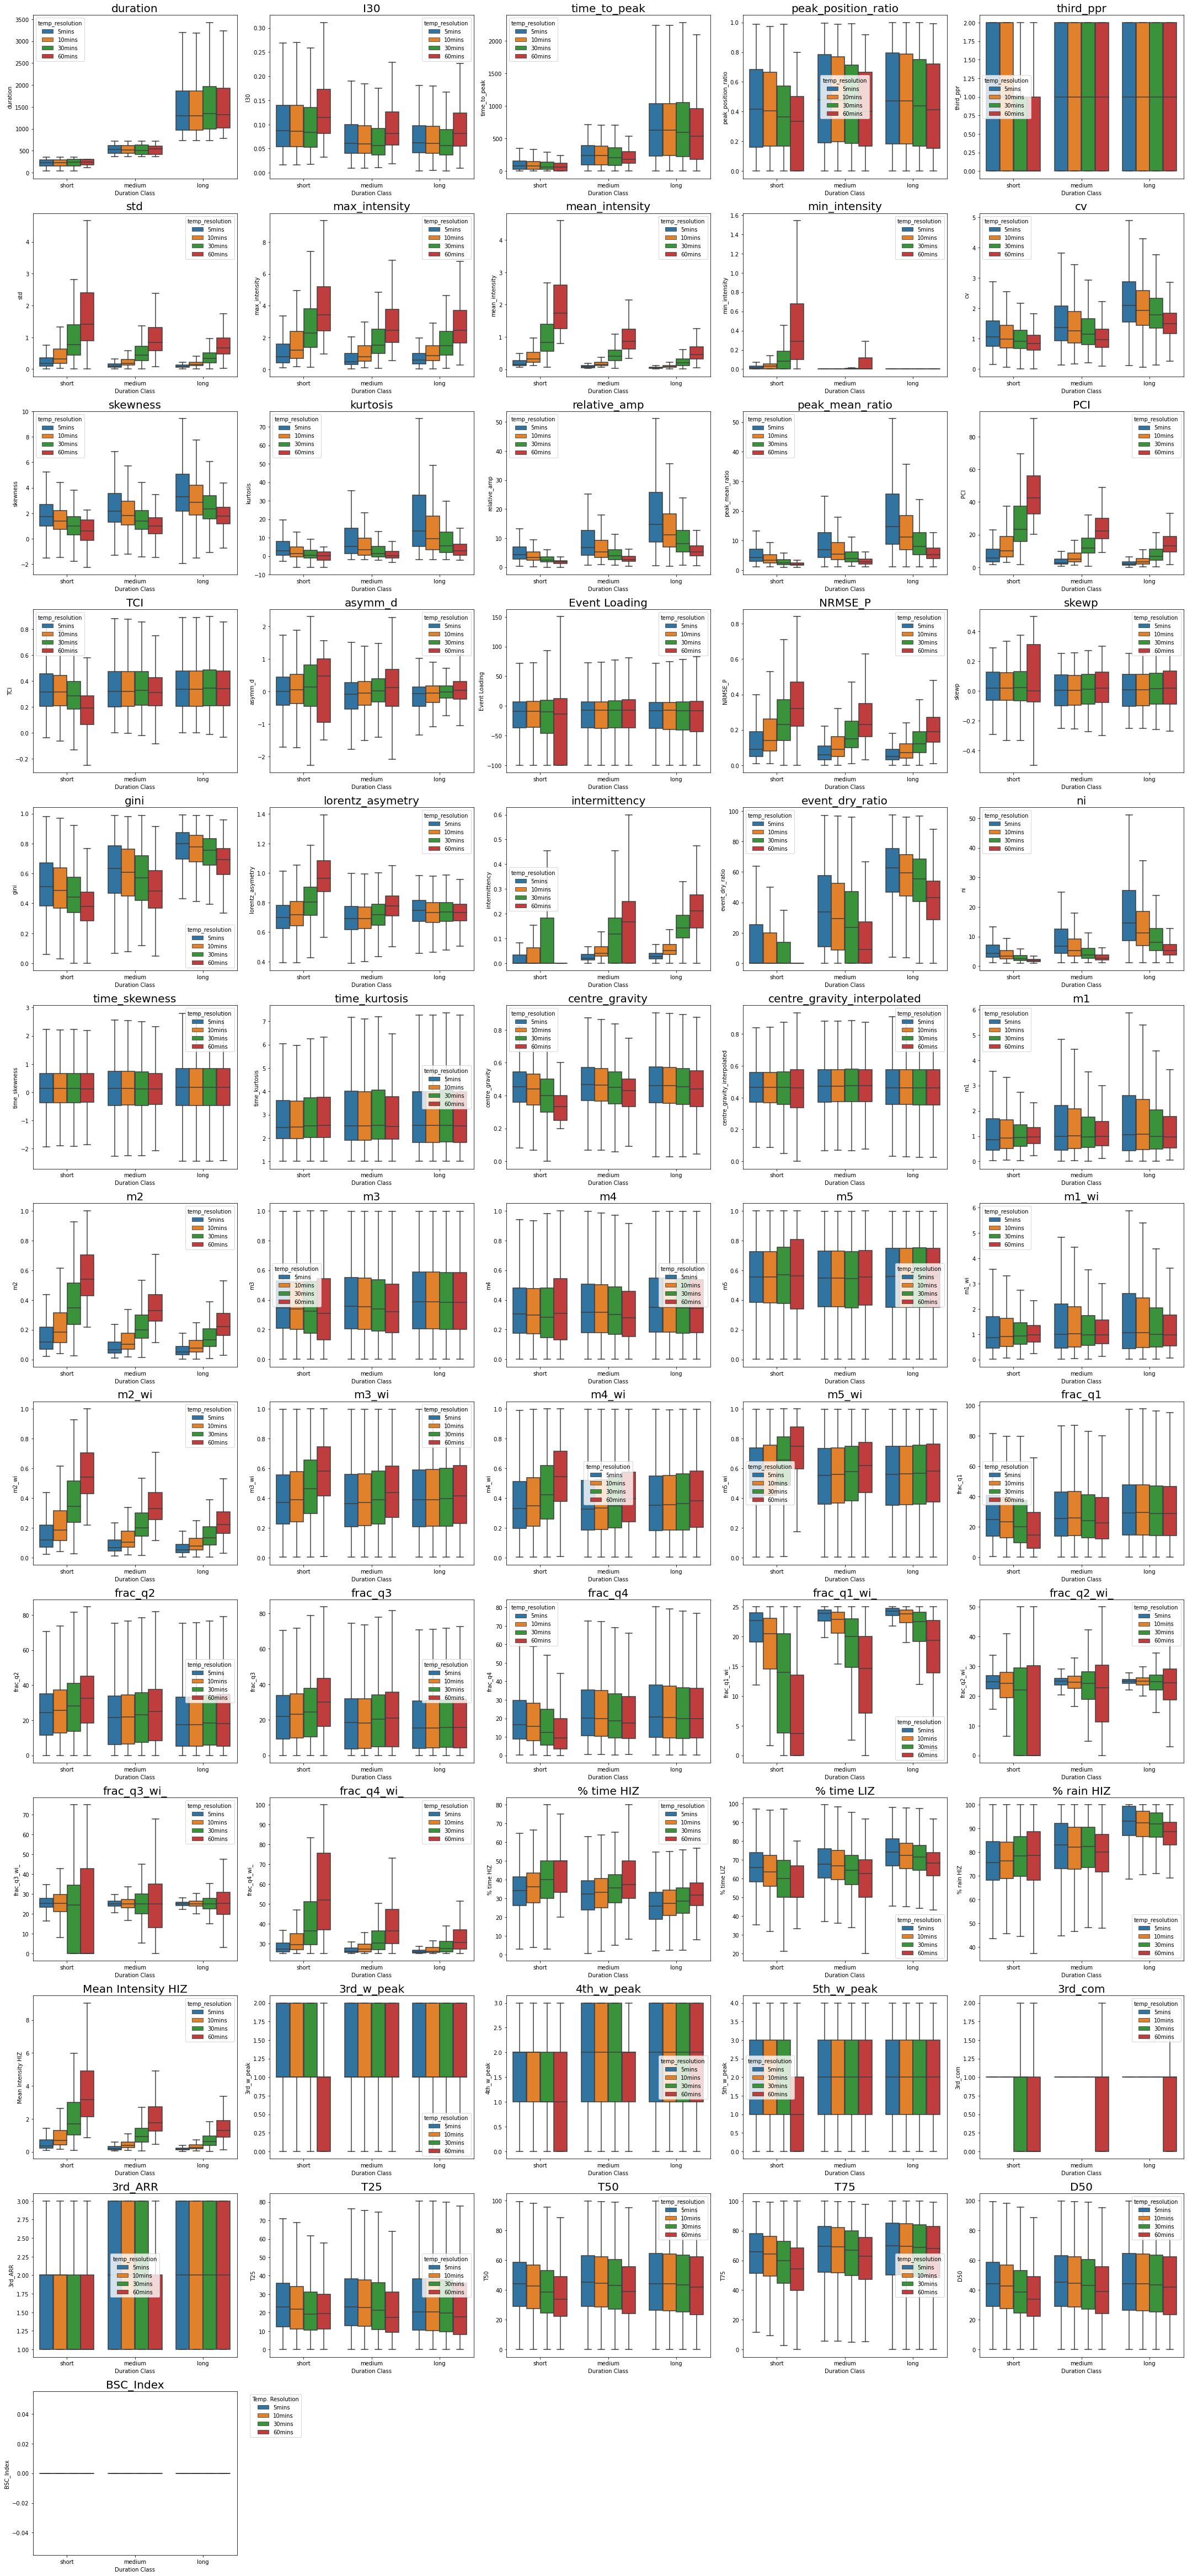

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

metrics = raw_cols

# Combine all data into a single DataFrame
all_data = []
for res in resolutions:
    df = temp_agg_dict[res].copy()
    df['temp_resolution'] = res
    df['duration_hrs'] = df['duration']/60
    df["duration_class"] = df['duration_hrs'].apply(duration_class)
    df.sort_values(by='duration_hrs', inplace=True, ascending=True)    
    all_data.append(df)
    
combined_df = pd.concat(all_data)

# Set up subplots: one per metric
n_metrics = len(metrics)
n_cols = 5  # adjust as needed
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), sharey=False)
axes = axes.flatten()  # Make indexing easier

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=combined_df,
        x='duration_class',
        y=metric,
        hue='temp_resolution',
        ax=axes[i],
        showfliers=False)
    axes[i].set_title(f"{metric}", fontsize =20)
    axes[i].set_xlabel("Duration Class")
    axes[i].set_ylabel(metric)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(title="Temp. Resolution", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [7]:
nan_columns = combined_df.columns[combined_df.isna().any()]
combined_df = combined_df.drop(columns=nan_columns)
nan_columns = combined_df.columns[combined_df.isna().any()]

In [8]:
raw_cols = []
for col in combined_df.columns:
    if not col.endswith('_DMC_10') and col not in ['gauge_num', 'event_num']:
        raw_cols.append(col)
        

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Filter for short duration events
short_duration_df = combined_df[combined_df['duration_class'] == 'short']

# Identify metric columns (excluding non-metric columns)
metric_columns = [col for col in combined_df.columns if col not in ['duration', 'duration_hrs', 'duration_class', 'temp_resolution', 'event_num', 'gauge_num']]

# Initialize a list to store results
results = []

# Loop through each metric
for metric in metric_columns:
    # Reference (5-minute) values
    ref_values = short_duration_df[short_duration_df['temp_resolution'] == '5mins'][['event_num', metric]].set_index('event_num')
    
    # Loop through other resolutions
    for res in ['10mins', '30mins', '60mins']:
        # Comparison values
        comp_values = short_duration_df[short_duration_df['temp_resolution'] == res][['event_num', metric]].set_index('event_num')
        
        # Align on event_num
        joined = ref_values.join(comp_values, lsuffix='_ref', rsuffix='_comp', how='inner')
        
        # Drop rows with NaN or infinite values
        joined = joined.replace([np.inf, -np.inf], np.nan).dropna()
        
        if not joined.empty:
            # Calculate MAE and RMSE
            mae = mean_absolute_error(joined[f"{metric}_ref"], joined[f"{metric}_comp"])
            rmse = np.sqrt(mean_squared_error(joined[f"{metric}_ref"], joined[f"{metric}_comp"]))
        else:
            mae = rmse = np.nan
        
        # Append results
        results.append({
            'Metric': metric,
            'Compared Resolution': res,
            'MAE': mae,
            'RMSE': rmse
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot the DataFrame for better readability
pivot_df = results_df.pivot_table(index=['Metric'], columns=['Compared Resolution'], values=['MAE', 'RMSE'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{stat}_{res}' for stat, res in pivot_df.columns]

# Display the results
print(pivot_df)


                      MAE_10mins  MAE_30mins  MAE_60mins  RMSE_10mins  \
Metric                                                                  
% rain HIZ             12.639141   13.523894   14.638610    15.709705   
% rain HIZ_DMC_10      12.020219   13.007382   16.203072    15.038017   
% time HIZ             12.708812   14.388958   16.450257    15.871093   
% time HIZ_DMC_10      13.310930   14.865028   19.056968    17.105962   
% time LIZ             12.721335   14.406827   16.454477    15.889747   
...                          ...         ...         ...          ...   
time_kurtosis           2.794246    3.393706    5.054380     6.183439   
time_kurtosis_DMC_10    2.600066    3.377179    5.607069     5.619260   
time_skewness           1.158256    1.233479    1.378576     1.614061   
time_skewness_DMC_10    1.120961    1.204133    1.352158     1.550160   
time_to_peak           90.421606   87.182122   83.138484   115.476244   

                      RMSE_30mins  RMSE_60mins  
M

In [29]:
import pandas as pd
from scipy.stats import ks_2samp

# Example metric and resolutions
metric = 'peak_intensity'
res1 = '5mins'
res2 = '60mins'

# Filter the data for each resolution
data_res1 = combined_df[combined_df['temp_resolution'] == res1]['D50'].dropna()
data_res2 = combined_df[combined_df['temp_resolution'] == res2]['D50'].dropna()

ks_statistic, p_value = ks_2samp(data_res1, data_res2)

print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}")
print(f"P-value: {p_value}")


Kolmogorov-Smirnov Statistic: 0.07677348111333643
P-value: 0.0


In [35]:
metrics = ['D50', 'peak_mean_ratio', 'centre_gravity']  # Replace with your actual metric names
resolutions = ['5mins', '10mins', '30mins', '60mins']  # Replace with your actual resolutions

results = []

for metric in metrics:
    base_data = combined_df[combined_df['temp_resolution'] == '5mins'][metric].dropna()
    for res in resolutions:
        if res == '5mins':
            continue  # Skip comparison with itself
        compare_data = combined_df[combined_df['temp_resolution'] == res][metric].dropna()
        ks_stat, p_val = ks_2samp(base_data, compare_data)
        results.append({
            'Metric': metric,
            'Resolution': res,
            'KS Statistic': ks_stat,
            'P-value': p_val
        })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

            Metric Resolution  KS Statistic        P-value
0              D50     10mins      0.009993   4.226197e-11
1              D50     30mins      0.034960  3.122475e-101
2              D50     60mins      0.076773   0.000000e+00
3  peak_mean_ratio     10mins      0.110334   0.000000e+00
4  peak_mean_ratio     30mins      0.242109   0.000000e+00
5  peak_mean_ratio     60mins      0.454484   0.000000e+00
6   centre_gravity     10mins      0.019608   1.598160e-41
7   centre_gravity     30mins      0.065655   0.000000e+00
8   centre_gravity     60mins      0.140446   0.000000e+00


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Filter for short duration events
short_duration_df = combined_df[combined_df['duration_class'] == 'short']

# Identify metric columns (excluding non-metric columns)
metric_columns = [col for col in combined_df.columns if col not in ['duration', 'duration_hrs', 'duration_class', 'temp_resolution', 'event_num', 'gauge_num']]

# Initialize a list to store results
results = []

# Loop through each metric
for metric in metric_columns:
    # Reference (5-minute) values
    ref_values = short_duration_df[short_duration_df['temp_resolution'] == '5mins'][['event_num', metric]].set_index('event_num')
    
    # Calculate mean and standard deviation of reference values
    mean_ref = ref_values[metric].mean()
    std_ref = ref_values[metric].std()
    
    # Loop through other resolutions
    for res in ['10mins', '30mins', '60mins']:
        # Comparison values
        comp_values = short_duration_df[short_duration_df['temp_resolution'] == res][['event_num', metric]].set_index('event_num')
        
        # Align on event_num
        joined = ref_values.join(comp_values, lsuffix='_ref', rsuffix='_comp', how='inner')
        
        # Drop rows with NaN or infinite values
        joined = joined.replace([np.inf, -np.inf], np.nan).dropna()
        
        if not joined.empty:
            # Calculate MAE and RMSE
            mae = mean_absolute_error(joined[f"{metric}_ref"], joined[f"{metric}_comp"])
            rmse = np.sqrt(mean_squared_error(joined[f"{metric}_ref"], joined[f"{metric}_comp"]))
            
            # Calculate Relative MAE (%) and NRMSE
            rel_mae = (mae / mean_ref) * 100 if mean_ref != 0 else np.nan
            nrmse = rmse / std_ref if std_ref != 0 else np.nan
        else:
            mae = rmse = rel_mae = nrmse = np.nan
        
        # Append results
        results.append({
            'Metric': metric,
            'Compared Resolution': res,
            'MAE': mae,
            'RMSE': rmse,
            'Relative MAE (%)': rel_mae,
            'NRMSE': nrmse
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot the DataFrame for better readability
pivot_df = results_df.pivot_table(index='Metric', columns='Compared Resolution', values=['Relative MAE (%)', 'NRMSE'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{metric}_{res}' for metric, res in pivot_df.columns]

,Metric,Compared Resolution,MAE,RMSE,Relative MAE (%),NRMSE
0,I30,10mins,0.093829,0.157749,79.190307,1.406968
1,I30,30mins,0.091474,0.153639,77.203047,1.370312
2,I30,60mins,0.104108,0.174058,87.865845,1.552430
3,time_to_peak,10mins,90.421606,115.476244,91.982098,1.385284
4,time_to_peak,30mins,87.182122,111.430020,88.686707,1.336745
...,...,...,...,...,...,...
310,BSC_DMC_10,30mins,537.736112,740.230543,96.474581,1.421654
311,BSC_DMC_10,60mins,545.130446,749.687789,97.801189,1.439818
312,BSC_Index_DMC_10,10mins,1.854489,2.467066,-106.480146,1.407199
313,BSC_Index_DMC_10,30mins,1.841119,2.464983,-105.712476,1.406011


In [13]:
pivot_df

,NRMSE_10mins,NRMSE_30mins,NRMSE_60mins,Relative MAE (%)_10mins,Relative MAE (%)_30mins,Relative MAE (%)_60mins
Metric,,,,,,
% rain HIZ,1.383911,1.481035,1.592472,16.574154,17.734363,19.196129
% rain HIZ_DMC_10,1.428221,1.582777,1.998685,15.617938,16.900565,21.052743
% time HIZ,1.444309,1.636235,1.853894,37.489102,42.445280,48.525808
% time HIZ_DMC_10,1.404327,1.570109,1.944244,34.357303,38.368639,49.188600
% time LIZ,1.445161,1.637146,1.853200,19.250177,21.800696,24.899241
...,...,...,...,...,...,...
time_kurtosis,1.409644,2.553538,6.644553,75.968923,92.266835,137.416632
time_kurtosis_DMC_10,1.392379,3.378429,11.024834,72.731411,94.469528,156.846065
time_skewness,1.392994,1.553841,1.933086,685.968633,730.519459,816.451868


In [14]:
df_melted

,Metric,Resolution_Metric,Value,Metric_Type,Resolution
0,% rain HIZ,NRMSE_10mins,1.383911,NRMSE,10mins
1,% rain HIZ_DMC_10,NRMSE_10mins,1.428221,NRMSE,10mins
2,% time HIZ,NRMSE_10mins,1.444309,NRMSE,10mins
3,% time HIZ_DMC_10,NRMSE_10mins,1.404327,NRMSE,10mins
4,% time LIZ,NRMSE_10mins,1.445161,NRMSE,10mins
...,...,...,...,...,...
175,Mean Intensity HIZ_DMC_10,Relative MAE (%)_60mins,76.623124,NaN,NaN
176,NRMSE_P,Relative MAE (%)_60mins,180.729136,NaN,NaN
177,NRMSE_P_DMC_10,Relative MAE (%)_60mins,85.403190,NaN,NaN
178,PCI,Relative MAE (%)_60mins,431.515453,NaN,NaN


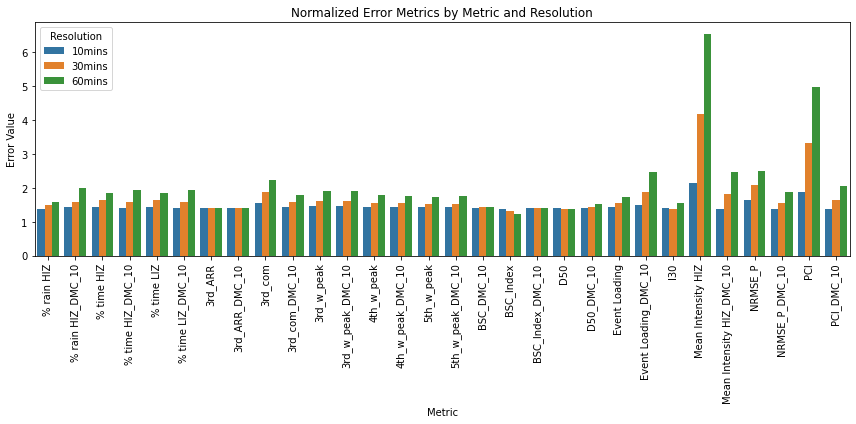

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'pivot_df' is your DataFrame with normalized error metrics
# Reset index to use 'Metric' as a column
df = pivot_df.reset_index()
df = df.iloc[:30,:]
# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars='Metric', var_name='Resolution_Metric', value_name='Value')

# Split 'Resolution_Metric' into 'Metric_Type' and 'Resolution'
df_melted[['Metric_Type', 'Resolution']] = df_melted['Resolution_Metric'].str.extract(r'(\w+)\_(\d+mins)')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Metric', y='Value', hue='Resolution')
plt.title('Normalized Error Metrics by Metric and Resolution')
plt.ylabel('Error Value')
plt.xticks(rotation=90)
plt.legend(title='Resolution')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
df_line = results_df.copy()
df_line['Resolution'] = df_line['Compared Resolution']
df_line['Metric_Name'] = df_line['Metric']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_line, x='Resolution', y='Relative MAE (%)', hue='Metric_Name', marker='o')
plt.title('Relative MAE (%) Across Resolutions')
plt.ylabel('Relative MAE (%)')
plt.xlabel('Resolution')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data
labels = pivot_df.index.tolist()
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Repeat the first value to close the circle
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each resolution
for res in ['10mins', '30mins', '60mins']:
    values = pivot_df[f'Relative MAE (%)_{res}'].tolist()
    values += values[:1]  # Repeat first value
    ax.plot(angles, values, label=res)
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Relative MAE (%) by Metric and Resolution')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_melted has columns: 'metric', 'duration_class', 'temp_resolution', 'value'
g = sns.FacetGrid(df_melted, col="Metric", col_wrap=4, sharey=False, height=4)

# Use boxplot or stripplot as needed
g.map_dataframe(sns.boxplot, x="Compared Resolution", y="Value", hue="Duration Class")

# Adjust y-axis per facet
for ax, metric in zip(g.axes.flat, df_melted['Metric'].unique()):
    subset = df_melted[df_melted['Metric'] == metric]
    ymin, ymax = subset['Value'].min(), subset['Value'].max()
    margin = (ymax - ymin) * 0.1 if ymax > ymin else 1
    ax.set_ylim(ymin - margin, ymax + margin)
    ax.set_title(metric)

g.add_legend()
plt.tight_layout()
plt.show()
